# CNN 2.0 with CIFAR-10

### Imports and dataset init

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Creating train/vali split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

valset.dataset.transform = transform_test  # For validation we switch to transform_test (no augmentation)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

In [6]:
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Building CNN

In [7]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x32x32, Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 32x16x16
            # nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 64x8x8
            # nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 128x8x8
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 128x4x4
            # nn.Dropout(0.2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 128x4x4
            nn.ReLU(),
            nn.MaxPool2d(2),                           # 128x2x2
            # nn.Dropout(0.2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 128x2x2
            nn.ReLU(),
            nn.MaxPool2d(2)                            # 128x1x1
            # nn.Dropout(0.3)
        )

        # 2 fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 1 * 1, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [8]:
model = BaseCNN().to(device)

learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

### Training loop and eval

In [9]:
num_epochs = 100  # TODO: Add auto stopping criterion if loss is not decreasing
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    scheduler.step()

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

Epoch [10/100], Loss: 0.282550
Epoch [20/100], Loss: 0.097578
Epoch [30/100], Loss: 0.071254
Epoch [40/100], Loss: 0.052998
Epoch [50/100], Loss: 0.056723
Epoch [60/100], Loss: 0.047615
Epoch [70/100], Loss: 0.029863
Epoch [80/100], Loss: 0.035642
Epoch [90/100], Loss: 0.022721
Epoch [100/100], Loss: 0.029134


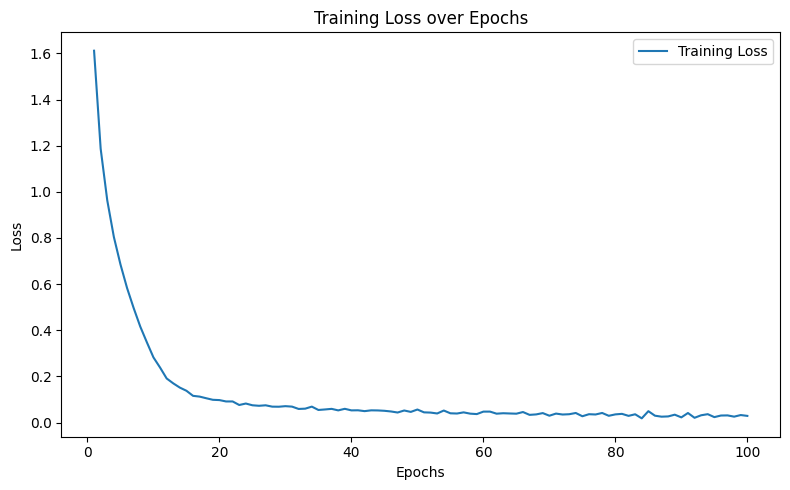

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print("\nTest Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=testset.classes, zero_division=0))


Test Metrics:
Accuracy: 0.7394
Precision: 0.7425
Recall: 0.7394
F1-Score: 0.7395

Classification Report:
               precision    recall  f1-score   support

    airplane       0.80      0.76      0.78      1000
  automobile       0.86      0.87      0.86      1000
        bird       0.63      0.67      0.65      1000
         cat       0.57      0.52      0.55      1000
        deer       0.67      0.72      0.69      1000
         dog       0.61      0.67      0.64      1000
        frog       0.78      0.81      0.79      1000
       horse       0.83      0.72      0.77      1000
        ship       0.80      0.89      0.84      1000
       truck       0.88      0.77      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



### Show random predictions

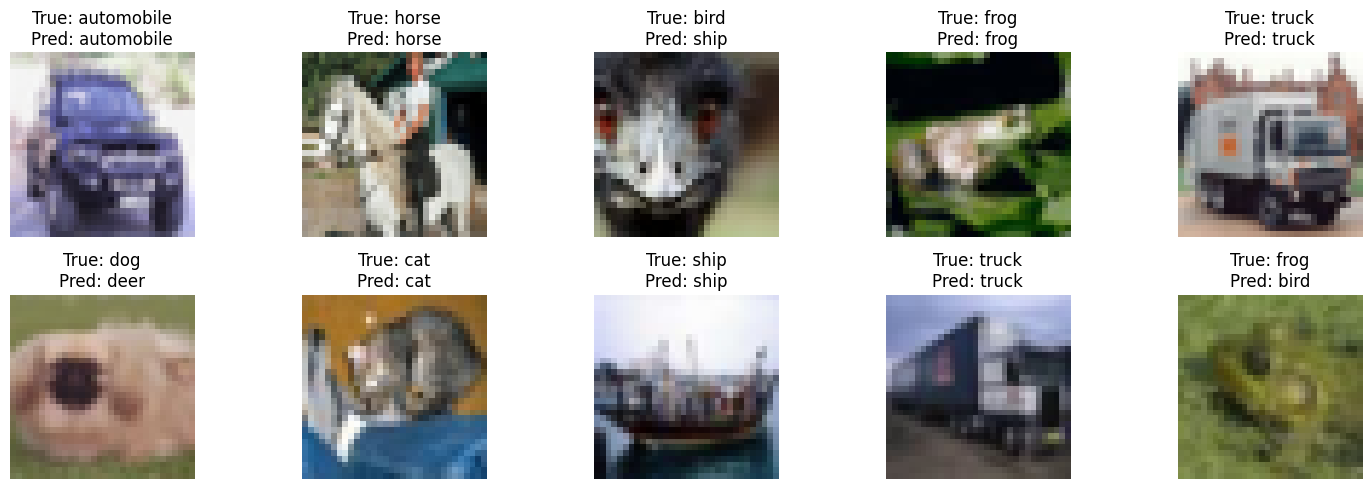

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # remove normalization from transform
    np_img = img.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    plt.axis('off')

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

indices = random.sample(range(images.size(0)), 10)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    imshow(images[idx].cpu())
    true_label = testset.classes[labels[idx].item()]
    pred_label = testset.classes[preds[idx].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.tight_layout()
plt.show()